In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import time

In [2]:
exe_dir = "/home/aswathy/DATA_ANALYSIS/datalab/code"
data_dir = "/home/aswathy/DATA_ANALYSIS/datalab/solutions/Exercise_3"

In [3]:
"""
Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>]
                          [-a <float>] [-r <int>]
  -o, --output=<file>       output file
  -s, --sigma=<float>       standard deviation sigma
  -d, --deltaT=<float>      delta T betwean measurements
  -N, --length=<int>        number of elements
  -f, --freq=<float>        frequency
  -p, --phase=<float>       phase
  -a, --amplitude=<float>   signal amplitude
  -r, --random=<int>        if set to 1, generate random signal
  -h, --help                print this help and exit
"""      

def generate_source(outputFile=None, sigma=0, f=0, A=0, delta_T=None, N=10000, phi=0, r=0):
    if delta_T == None : 
        delta_T = 1/N
       
    dataPath = os.path.join(data_dir, outputFile)
    exe_path = os.path.join(exe_dir, 'generate_source')
    cmd_str = f"{exe_path} -o {dataPath} -s {sigma} -d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print('The process has an output:', out.decode())

    return

In [4]:
"""
Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
  -i, --input=<file>        input file
  -o, --output=<file>       output file
  -f, --freq=<float>        frequency
  -p, --phase=<float>       phase
  -h, --help                print this help and exit
  -t, --templatebank=<file> template bank file
  -m, --method=<int>        select method to analyze signal 1, 2 or 3
"""

def prober(inputFile, f=0, outputFile=None, phi=0, template=None, mod=0):
    
    exe_path = os.path.join(exe_dir, 'prober')
    cmd_str = f"{exe_path} -i {data_dir}/{inputFile} -o {data_dir}/{outputFile} -m {mod}"
    if template:
        cmd_str += f" -t {data_dir}/{template} "
    else:
        cmd_str += f" -f {f} -p {phi}"
        
    #print(cmd_str)
        
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    #if out:
        #print('The process has an output:', out.decode())
        
    if out:
        if template:
            print('The process has an output:', out.decode())
        else:
            with open(f"{data_dir}/output_S{mod}.txt", "w") as file:
                print('The process has an output:', out.decode())
                file.write(out.decode())
                #return f"output_S{mod}.txt"
    if mod == 3:
        if template:
            print(cmd_str)
        else:
            data = np.loadtxt(f"{data_dir}/{outputFile}")
            with open(f"{data_dir}/output_S{mod}.txt", "w") as file:
                file.write("{0: .1f}".format(data[f][0]) + " {0:.1f}".format(data[f][1]) + " {0:.1f}".format(data[f][2]))
                #file.write("{0}\n".format(data[f]))
                #return f"output_S{mod}.txt"
    
    return f"output_S{mod}.txt"

In [44]:
"""
data_set = {
    1: {
        'sigma': 0.0,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_01.csv",
        'title': "-s 0 -a 1",
    },
    2: {
        'sigma': 0.5,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_02.csv",
        'title': "-s 0.5 -a 1",
    },
    3: {
        'sigma': 5,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_03.csv",
        'title': "-s 5 -a 1",
    },
    4: {
        'sigma': 10,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_04.csv",
        'title': "-s 10 -a 1",
    },
    5 : {
        'sigma': 10,
        'A': 0,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_05.csv",
        'title': "-s 10 -a 0",
    }
}

for key, value in data_set.items():
    generate_source(value.get('filename'), sigma=value.get('sigma'), A=value.get('A'), f=value.get('f'), delta_T=value.get('delta_T'))
"""
    
data_files = []
nf = 100
frq = np.linspace(0.5, 100.0, nf)
for n in range(nf):
    data_files.append(generate_source(f"data_0{n}.csv",sigma=5, A=1, f=frq[n]))
with open(f"{data_dir}/true_freq.csv", "w") as file:
    for i in range(nf):
        file.write("{0}\n".format(frq[i]))

In [5]:
#Define a function to calculate the Mismatch
def mismatch(iFile, resultsFile, mode, freq=0, p=0, nfrq=0, nphi=0):
    #Create a template bank
    if nphi == 0:
        frq = np.linspace(0.01, 100.0, nfrq)
        with open(f"{data_dir}/temp_bank_{nfrq}.csv", "w") as file:
            for i in range(nfrq):
                file.write("{0} {1}\n".format(frq[i],0))
        tbank = f"temp_bank_{nfrq}.csv"
    else:
        frq = np.linspace(0.01, 100.0, nfrq)
        ph = np.linspace(0, 2*np.pi, nphi)
        with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
            for i in range(nfrq):
                for j in range(nphi):
                    file.write("{0} {1}\n".format(frq[i], ph[j]))
        tbank = f"temp_bank_{nfrq}_{nphi}.csv"
    
    
    OFile_1 = prober(inputFile=iFile, f=freq, outputFile=resultsFile, phi=p, mod=mode)
    prober(inputFile=iFile, outputFile=resultsFile, template=tbank, mod=mode)
    
        
    if mode == 2:
        data1 = np.loadtxt(os.path.join(data_dir, OFile_1))
        s_true = data1[2]
        print("Minimum Value at f: ",s_true)
        data2 = np.loadtxt(os.path.join(data_dir, resultsFile))
        s = np.where(data2[:,2] == np.min(data2[:,2]))
        s_best = data2[:,2][s][0]
        print("Minimum value at best f: ",s_best)
        M = 1 - abs(float(s_true)-float(s_best)/float(s_true))
    else:
        data1 = np.loadtxt(os.path.join(data_dir, OFile_1))
        s_true = data1[2]
        print("Maximum Value at f : ",s_true)
        data2 = np.loadtxt(os.path.join(data_dir, resultsFile))
        s = np.where(data2[:,2] == np.max(data2[:,2]))
        s_best = data2[:,2][s][0]
        print("Maximum value at best f: ",s_best)
        M = 1 - float(s_best)/float(s_true)
    
    print("Mismatch: ",M)
    print("\n")
    
    #if nphi == 0:
        #return f"{freq} {M}"
    #else:
        #return f"{freq} {p} {M}"
        
    return M

In [45]:
# a = 1, s = 0, f = 30, p = 0
values = []
for n in range(nf):
    values.append(mismatch(f"data_0{n}.csv", resultsFile=f"results_1_S1.csv", mode=1, freq=frq[n], p=0, nfrq=300, nphi=0))
#os.system(f"echo '{data}' >> {data_dir}/values_S1.csv")


The process has an output: 0.5 0 0.556535

Maximum Value at f :  0.556535
Maximum value at best f:  0.592851
Mismatch:  -0.06525375762530672


The process has an output: 1.50505 0 0.418601

Maximum Value at f :  0.418601
Maximum value at best f:  0.356237
Mismatch:  0.1489819661204822


The process has an output: 2.5101 0 0.496276

Maximum Value at f :  0.496276
Maximum value at best f:  0.464193
Mismatch:  0.06464749453932883


The process has an output: 3.51515 0 0.509634

Maximum Value at f :  0.509634
Maximum value at best f:  0.46031
Mismatch:  0.09678318165585509


The process has an output: 4.5202 0 0.555089

Maximum Value at f :  0.555089
Maximum value at best f:  0.465876
Mismatch:  0.16071837128820787


The process has an output: 5.52525 0 0.510206

Maximum Value at f :  0.510206
Maximum value at best f:  0.464725
Mismatch:  0.08914242482448276


The process has an output: 6.5303 0 0.549262

Maximum Value at f :  0.549262
Maximum value at best f:  0.471999
Mismatch:  0.140666

Maximum Value at f :  0.503884
Maximum value at best f:  0.489474
Mismatch:  0.02859785188654529


The process has an output: 58.7929 0 0.459886

Maximum Value at f :  0.459886
Maximum value at best f:  0.440197
Mismatch:  0.042812784037783325


The process has an output: 59.798 0 0.436675

Maximum Value at f :  0.436675
Maximum value at best f:  0.433218
Mismatch:  0.00791664281216009


The process has an output: 60.803 0 0.489047

Maximum Value at f :  0.489047
Maximum value at best f:  0.473956
Mismatch:  0.030857974795878595


The process has an output: 61.8081 0 0.430497

Maximum Value at f :  0.430497
Maximum value at best f:  0.414596
Mismatch:  0.03693637818614304


The process has an output: 62.8131 0 0.488492

Maximum Value at f :  0.488492
Maximum value at best f:  0.474745
Mismatch:  0.02814170958787454


The process has an output: 63.8182 0 0.509904

Maximum Value at f :  0.509904
Maximum value at best f:  0.505103
Mismatch:  0.009415497819197483


The process has an outpu

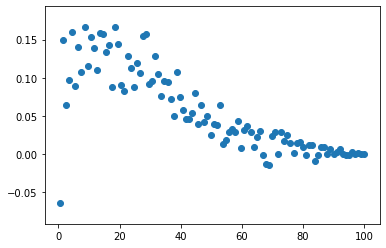

In [47]:
#print(values)
#data_values = np.loadtxt(f"{data_dir}/values_S1.csv")
plt.scatter(frq,values)
#plt.xlabel("nfrq")
#plt.ylabel("mismatch")

In [23]:
"""
generate_source(f"data_06.csv", sigma=5, A=0, f=30)
generate_source(f"data_07.csv", sigma=5, A=1, f=30)
prober(f"data_06.csv", f=30, outputFile="results_6_S1", phi=0, mod=1)
prober(f"data_07.csv", f=30, outputFile="results_7_S1", phi=0, mod=1)
"""
generate_source(f"data_06.csv", sigma=5, N=1000)
generate_source(f"data_07.csv", sigma=5, A=1, f=30, N=1000)
prober(f"data_06.csv", f=30, outputFile="results_6_S1", phi=0, mod=1)
prober(f"data_07.csv", f=30, outputFile="results_7_S1", phi=0, mod=1)

The process has an output: 30 0 0.0297192

The process has an output: 30 0 0.53022



'output_S1.txt'

In [67]:
#n = 1000
#freq = np.linspace(0.01, 100.0, n)
#with open(f"{data_dir}/temp_bank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))

#prober(f"data_06.csv", f=30, outputFile="results_06_S1.csv", template="temp_bank.csv", mod=1)
#prober(f"data_07.csv", f=30, outputFile="results_07_S1.csv", template="temp_bank.csv", mod=1)

#mismatch(f"data_06.csv", resultsFile=f"results_06_S1.csv", mode=1, freq=30, p=0, nfrq=2000, nphi=0)
#mismatch(f"data_07.csv", resultsFile=f"results_07_S1.csv", mode=1, freq=30, p=0, nfrq=2000, nphi=0)

In [24]:
data2 = np.loadtxt(f"{data_dir}/results_06_S1.csv")
data2 = data2[:,2]
data3 = np.loadtxt(f"{data_dir}/results_07_S1.csv")
data3 = data3[:,2]
#plt.hist([data2,data3],bins='auto', label=['noise','signal+noise'])
#plt.legend(loc='upper right')

(array([  3.,   3.,   3.,   3.,   3.,   1.,   5.,   3.,   2.,  11.,  15.,
         18.,  18.,  25.,  41.,  42.,  53.,  44.,  47.,  57.,  66.,  62.,
         96.,  85.,  88.,  88.,  83.,  97.,  94., 100.,  85.,  93.,  79.,
         61.,  62.,  62.,  60.,  35.,  38.,  35.,  37.,  15.,  19.,  14.,
          8.,  13.,   9.,  10.,   5.,   4.]),
 array([-0.120617 , -0.1162044, -0.1117918, -0.1073792, -0.1029666,
        -0.098554 , -0.0941414, -0.0897288, -0.0853162, -0.0809036,
        -0.076491 , -0.0720784, -0.0676658, -0.0632532, -0.0588406,
        -0.054428 , -0.0500154, -0.0456028, -0.0411902, -0.0367776,
        -0.032365 , -0.0279524, -0.0235398, -0.0191272, -0.0147146,
        -0.010302 , -0.0058894, -0.0014768,  0.0029358,  0.0073484,
         0.011761 ,  0.0161736,  0.0205862,  0.0249988,  0.0294114,
         0.033824 ,  0.0382366,  0.0426492,  0.0470618,  0.0514744,
         0.055887 ,  0.0602996,  0.0647122,  0.0691248,  0.0735374,
         0.07795  ,  0.0823626,  0.0867752,  0

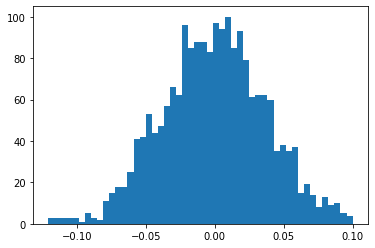

In [25]:
plt.hist(data2, bins=50)

(array([  3.,  12.,  15.,  45.,  60.,  72., 157., 173., 258., 273., 305.,
        247., 133., 108.,  78.,  23.,  14.,   7.,   0.,   1.,   1.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          2.,   0.,   0.,   2.,   0.,   3.]),
 array([-0.130447 , -0.1167258, -0.1030046, -0.0892834, -0.0755622,
        -0.061841 , -0.0481198, -0.0343986, -0.0206774, -0.0069562,
         0.006765 ,  0.0204862,  0.0342074,  0.0479286,  0.0616498,
         0.075371 ,  0.0890922,  0.1028134,  0.1165346,  0.1302558,
         0.143977 ,  0.1576982,  0.1714194,  0.1851406,  0.1988618,
         0.212583 ,  0.2263042,  0.2400254,  0.2537466,  0.2674678,
         0.281189 ,  0.2949102,  0.3086314,  0.3223526,  0.3360738,
         0.349795 ,  0.3635162,  0.3772374,  0.3909586,  0.4046798,
         0.418401 ,  0.4321222,  0.4458434,  0.4595646,  0.4732858,
         0.487007 ,  0.5007282,  0.5144494,  0

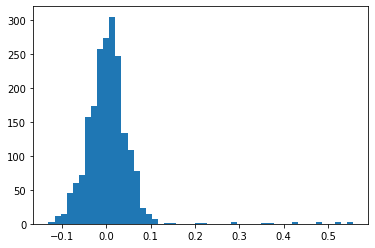

In [26]:
#plt.figure(figsize=(10,6))
plt.hist(data3, bins=50)

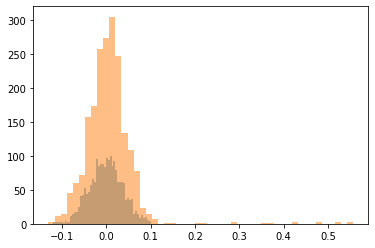

In [27]:
plt.hist(data2, bins=50, alpha=0.5)
plt.hist(data3, bins=50, alpha=0.5)
plt.show()

In [7]:
results_n_10 = np.zeros(200)
results_s_10 = np.zeros(200)

#n = 1000
#freq = np.linspace(25, 35, n)
#with open(f"{data_dir}/hist_tbank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))

for i in range(200):
    generate_source(f"noise_{i}.csv", sigma=10, N=1000)
    File1 = prober(f"noise_{i}.csv", f=30, outputFile=f"results_noise_{i}_S1.csv", phi=0, mod=1)
    data4 = np.loadtxt(os.path.join(data_dir, File1))
    results_n_10[i] = data4[2]    
    generate_source(f"signal_{i}.csv", sigma=10, A=2, f=30, N=1000)
    File2 = prober(f"signal_{i}.csv", f=30, outputFile=f"results_signal_{i}_S1.csv", phi=0, mod=1)
    data5 = np.loadtxt(os.path.join(data_dir, File2))
    results_s_10[i] = data5[2]

The process has an output: 30 0 -0.109053

The process has an output: 30 0 1.09203

The process has an output: 30 0 0.554019

The process has an output: 30 0 0.746603

The process has an output: 30 0 -0.434442

The process has an output: 30 0 0.578434

The process has an output: 30 0 0.0441948

The process has an output: 30 0 0.96799

The process has an output: 30 0 0.11978

The process has an output: 30 0 0.826693

The process has an output: 30 0 -0.403548

The process has an output: 30 0 1.17617

The process has an output: 30 0 -0.192066

The process has an output: 30 0 0.773018

The process has an output: 30 0 0.0151216

The process has an output: 30 0 0.668135

The process has an output: 30 0 -0.263884

The process has an output: 30 0 0.776728

The process has an output: 30 0 -0.27102

The process has an output: 30 0 1.21206

The process has an output: 30 0 0.00334901

The process has an output: 30 0 1.23019

The process has an output: 30 0 -0.451099

The process has an output: 30 

The process has an output: 30 0 -0.110845

The process has an output: 30 0 1.26168

The process has an output: 30 0 -0.39808

The process has an output: 30 0 1.27032

The process has an output: 30 0 -0.236033

The process has an output: 30 0 0.961543

The process has an output: 30 0 0.461308

The process has an output: 30 0 1.16389

The process has an output: 30 0 -0.333165

The process has an output: 30 0 0.979214

The process has an output: 30 0 0.182122

The process has an output: 30 0 1.04874

The process has an output: 30 0 0.0185621

The process has an output: 30 0 0.939094

The process has an output: 30 0 0.258111

The process has an output: 30 0 1.09417

The process has an output: 30 0 0.101259

The process has an output: 30 0 1.41525

The process has an output: 30 0 0.0351802

The process has an output: 30 0 1.25578

The process has an output: 30 0 0.0564266

The process has an output: 30 0 0.737648

The process has an output: 30 0 0.0129469

The process has an output: 30 0 1.

The process has an output: 30 0 0.88995

The process has an output: 30 0 -0.00759328

The process has an output: 30 0 0.879322

The process has an output: 30 0 0.0230628

The process has an output: 30 0 1.58046

The process has an output: 30 0 0.405581

The process has an output: 30 0 1.33438

The process has an output: 30 0 -0.0037627

The process has an output: 30 0 1.39774



(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  1.,
         3.,  2.,  1.,  2.,  5.,  9.,  3.,  5.,  8.,  4.,  7., 16.,  6.,
         7., 13., 12.,  9.,  7.,  6.,  7., 10.,  4.,  7.,  6.,  4.,  5.,
         7.,  6.,  2.,  1.,  1.,  2.,  2.,  1.,  1.,  0.,  3.]),
 array([-0.779608  , -0.75359064, -0.72757328, -0.70155592, -0.67553856,
        -0.6495212 , -0.62350384, -0.59748648, -0.57146912, -0.54545176,
        -0.5194344 , -0.49341704, -0.46739968, -0.44138232, -0.41536496,
        -0.3893476 , -0.36333024, -0.33731288, -0.31129552, -0.28527816,
        -0.2592608 , -0.23324344, -0.20722608, -0.18120872, -0.15519136,
        -0.129174  , -0.10315664, -0.07713928, -0.05112192, -0.02510456,
         0.0009128 ,  0.02693016,  0.05294752,  0.07896488,  0.10498224,
         0.1309996 ,  0.15701696,  0.18303432,  0.20905168,  0.23506904,
         0.2610864 ,  0.28710376,  0.31312112,  0.33913848,  0.36515584,
         0.3911732 ,  0.41719056,  0.44320792,  0.46922528,

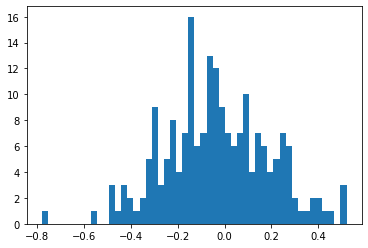

In [101]:
plt.hist(results_n_10, bins=50)

(array([ 2.,  1.,  1.,  0.,  2.,  0.,  2.,  1.,  4.,  4.,  8.,  3.,  1.,
         2.,  5.,  8.,  5.,  6.,  7.,  8.,  8., 10.,  8.,  7.,  6., 11.,
         9.,  5., 10., 10.,  4.,  5.,  2.,  3.,  6.,  4.,  4.,  2.,  1.,
         3.,  2.,  0.,  1.,  2.,  4.,  0.,  0.,  2.,  0.,  1.]),
 array([0.444299  , 0.46758362, 0.49086824, 0.51415286, 0.53743748,
        0.5607221 , 0.58400672, 0.60729134, 0.63057596, 0.65386058,
        0.6771452 , 0.70042982, 0.72371444, 0.74699906, 0.77028368,
        0.7935683 , 0.81685292, 0.84013754, 0.86342216, 0.88670678,
        0.9099914 , 0.93327602, 0.95656064, 0.97984526, 1.00312988,
        1.0264145 , 1.04969912, 1.07298374, 1.09626836, 1.11955298,
        1.1428376 , 1.16612222, 1.18940684, 1.21269146, 1.23597608,
        1.2592607 , 1.28254532, 1.30582994, 1.32911456, 1.35239918,
        1.3756838 , 1.39896842, 1.42225304, 1.44553766, 1.46882228,
        1.4921069 , 1.51539152, 1.53867614, 1.56196076, 1.58524538,
        1.60853   ]),
 <a list of 50

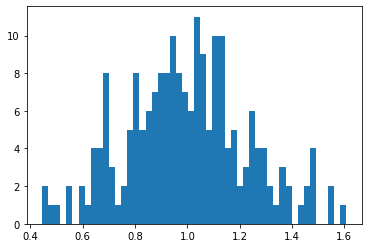

In [102]:
plt.hist(results_s_10, bins=50)

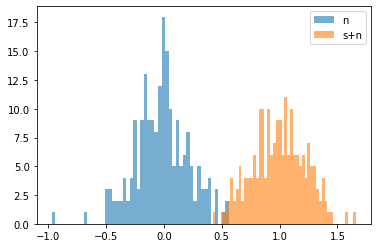

In [8]:
plt.hist(results_n_10, bins=50, alpha=0.6, label="n")
plt.hist(results_s_10, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

In [9]:
results_n_20 = np.zeros(200)
results_s_20 = np.zeros(200)

#n = 1000
#freq = np.linspace(25, 35, n)
#with open(f"{data_dir}/hist_tbank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))

for i in range(200):
    generate_source(f"noise_{i}.csv", sigma=20, N=1000)
    File3 = prober(f"noise_{i}.csv", f=30, outputFile=f"results_noise_{i}_S1.csv", phi=0, mod=1)
    data6 = np.loadtxt(os.path.join(data_dir, File3))
    results_n_20[i] = data6[2]    
    generate_source(f"signal_{i}.csv", sigma=20, A=2, f=30, N=1000)
    File4 = prober(f"signal_{i}.csv", f=30, outputFile=f"results_signal_{i}_S1.csv", phi=0, mod=1)
    data7 = np.loadtxt(os.path.join(data_dir, File4))
    results_s_20[i] = data7[2] 

The process has an output: 30 0 0.393999

The process has an output: 30 0 1.30823

The process has an output: 30 0 -0.183247

The process has an output: 30 0 1.14311

The process has an output: 30 0 0.483684

The process has an output: 30 0 1.17058

The process has an output: 30 0 -0.0375448

The process has an output: 30 0 -0.552544

The process has an output: 30 0 0.704361

The process has an output: 30 0 0.711668

The process has an output: 30 0 -0.287445

The process has an output: 30 0 1.91748

The process has an output: 30 0 0.20846

The process has an output: 30 0 1.40345

The process has an output: 30 0 -0.012898

The process has an output: 30 0 -0.103925

The process has an output: 30 0 -0.174322

The process has an output: 30 0 0.242937

The process has an output: 30 0 -0.0616637

The process has an output: 30 0 0.731345

The process has an output: 30 0 0.109583

The process has an output: 30 0 1.63853

The process has an output: 30 0 -0.0616325

The process has an output: 30

The process has an output: 30 0 -0.236212

The process has an output: 30 0 0.750114

The process has an output: 30 0 0.770454

The process has an output: 30 0 0.408519

The process has an output: 30 0 -0.689266

The process has an output: 30 0 0.38173

The process has an output: 30 0 -0.116644

The process has an output: 30 0 0.750318

The process has an output: 30 0 -0.727525

The process has an output: 30 0 1.33921

The process has an output: 30 0 -0.792165

The process has an output: 30 0 1.13435

The process has an output: 30 0 0.400475

The process has an output: 30 0 0.416997

The process has an output: 30 0 -0.167729

The process has an output: 30 0 0.777703

The process has an output: 30 0 -0.635358

The process has an output: 30 0 1.18199

The process has an output: 30 0 0.376917

The process has an output: 30 0 0.549213

The process has an output: 30 0 0.247648

The process has an output: 30 0 1.43217

The process has an output: 30 0 -0.703459

The process has an output: 30 0

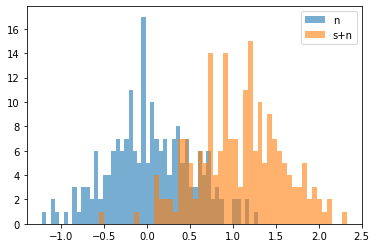

In [10]:
plt.hist(results_n_20, bins=50, alpha=0.6, label="n")
plt.hist(results_s_20, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

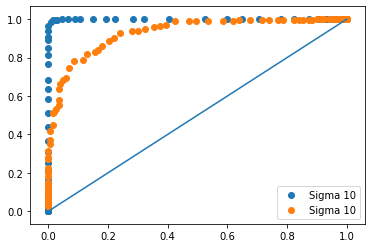

In [11]:
FP_10 = []
TP_10 = []
FP_20 = []
TP_20 = []

for t in np.linspace(-2,2,100):
    FP_10 = np.append(FP_10,len(np.where(results_n_10 >= t)[0])/len(results_n_10))
    TP_10 = np.append(TP_10,len(np.where(results_s_10 >= t)[0])/len(results_s_10))
    FP_20 = np.append(FP_20,len(np.where(results_n_20 >= t)[0])/len(results_n_20))
    TP_20 = np.append(TP_20,len(np.where(results_s_20 >= t)[0])/len(results_s_20))
    
plt.scatter(FP_10,TP_10,label="Sigma 10")
plt.scatter(FP_20,TP_20,label="Sigma 10")
plt.legend(loc="lower right")
plt.plot([0,1])
plt.show()
plt.close()

In [16]:
results_n_25 = np.zeros(100)
results_s_25 = np.zeros(100)

#n = 1000
#freq = np.linspace(25, 35, n)
#with open(f"{data_dir}/hist_tbank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))
        
nfrq = 500
nphi = 50
frq = np.linspace(0.01, 1000.0, nfrq)
phi = np.linspace(0, 2*np.pi, nphi)

with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq[i], phi[j]))

for i in range(100):
    generate_source(f"noise_{i}.csv", sigma=25, N=1000)
    prober(f"noise_{i}.csv", outputFile=f"results_noise_{i}_rand.csv", template=f"temp_bank_{nfrq}_{nphi}.csv", mod=1)   
    generate_source(f"signal_{i}.csv", sigma=25, A=5, N=1000, r=1)
    prober(f"signal_{i}.csv", outputFile=f"results_signal_{i}_rand.csv", template=f"temp_bank_{nfrq}_{nphi}.csv", mod=1)

The process has an output: 967.550543
6.079279

The process has an output: 760.808428
4.780150

The process has an output: 334.510482
2.101373

The process has an output: 265.493746
1.667685

The process has an output: 60.484489
0.379445

The process has an output: 997.205954
6.265628

The process has an output: 284.120778
1.784734

The process has an output: 934.991722
5.874685

The process has an output: 230.687027
1.448966

The process has an output: 520.932366
3.272814

The process has an output: 310.984945
1.953543

The process has an output: 963.992442
6.056921

The process has an output: 471.766729
2.963866

The process has an output: 903.046768
5.673949

The process has an output: 192.532932
1.209213

The process has an output: 494.907379
3.109277

The process has an output: 421.483438
2.647895

The process has an output: 218.625847
1.373176

The process has an output: 286.855106
1.801916

The process has an output: 723.761886
4.547356

The process has an output: 159.209505
0.9

In [38]:
results_n_25 = []
results_s_25 = []

for i in range(100):
    print(i)
    data8 = np.loadtxt(os.path.join(data_dir, f"results_noise_{i}_rand.csv"))  
    data9 = np.loadtxt(os.path.join(data_dir, f"results_signal_{i}_rand.csv"))
    for j in range(25000):
        results_n_25 = np.append(results_n_25,data8[j][2])
        results_s_25 = np.append(results_s_25,data9[j][2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


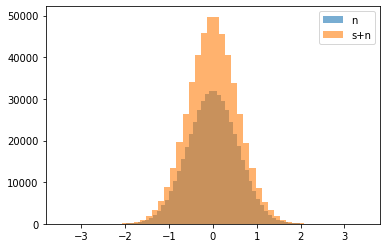

In [30]:
plt.hist(results_n_25, bins=50, alpha=0.6, label="n")
plt.hist(results_s_25, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

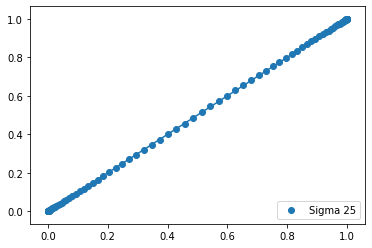

In [37]:
FP_25 = []
TP_25 = []

for t in np.linspace(-2,2,100):
    FP_25 = np.append(FP_25,len(np.where(results_n_25 >= t)[0])/len(results_n_25))
    TP_25 = np.append(TP_25,len(np.where(results_s_25 >= t)[0])/len(results_s_25))

plt.scatter(FP_25,TP_25,label="Sigma 25")
plt.legend(loc="lower right")
plt.plot([0,1])
plt.show()
plt.close()